In [11]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import warnings

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set default figure size
plt.rcParams['figure.figsize'] = (12, 8)


In [12]:
# ===================================================
# UTILITY FUNCTIONS
# ===================================================

def calculate_moving_average(data, window_size):
    """Calculate moving average for given window size"""
    return data.rolling(window=window_size).mean()

def create_features(data, lookback=7):
    """Create features for machine learning models"""
    features = []
    targets = []
    
    for i in range(lookback, len(data)):
        features.append(data[i-lookback:i])
        targets.append(data[i])
    
    return np.array(features), np.array(targets)

def fetch_stock_data(symbol, start_date, end_date):
    """Fetch stock data with error handling"""
    try:
        print(f"Fetching data for {symbol.upper()}...")
        data = yf.download(symbol, start=start_date, end=end_date, progress=False)
        if data.empty:
            print(f"No data found for {symbol}")
            return None
        
        # Reset index to make Date a column
        data.reset_index(inplace=True)
        print(f"Successfully fetched {len(data)} days of data")
        return data
    except Exception as e:
        print(f"Error fetching data for {symbol}: {str(e)}")
        return None

def display_stock_info(data, symbol):
    """Display basic stock information"""
    if data is None or len(data) == 0:
        print("No data to display")
        return
    
    print(f"\nStock Data Summary for {symbol.upper()}")
    print("-" * 50)
    
    current_price = float(data['Close'].iloc[-1])
    price_change = float(data['Close'].iloc[-1]) - float(data['Close'].iloc[-2])
    highest_price = float(data['High'].max())
    lowest_price = float(data['Low'].min())
    
    print(f"Current Price: ${current_price:.2f}")
    print(f"Daily Change: ${price_change:.2f} ({price_change/current_price*100:.2f}%)")
    print(f"Period High: ${highest_price:.2f}")
    print(f"Period Low: ${lowest_price:.2f}")
    print(f"Data Range: {data['Date'].iloc[0].strftime('%Y-%m-%d')} to {data['Date'].iloc[-1].strftime('%Y-%m-%d')}")
    
    # Display last 5 days
    print(f"\n Last 5 Days Data:")
    display_data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].tail(5)
    display_data = display_data.round(2)
    print(display_data.to_string(index=False))


In [13]:
# ===================================================
# FORECASTING FUNCTIONS
# ===================================================

def forecast_simple_nn(data):
    """Simple neural network approach without requiring saved model"""
    try:
        if len(data) < 30:
            print("Insufficient data for Neural Network prediction. Need at least 30 days.")
            return np.repeat(float(data.iloc[-1]), 7)
        
        # Simple moving average with trend
        recent_data = data[-30:]
        trend = (float(recent_data.iloc[-1]) - float(recent_data.iloc[-10])) / 10
        base_price = float(recent_data.iloc[-1])
        
        forecasts = []
        for i in range(7):
            predicted_price = base_price + (trend * (i + 1)) + np.random.normal(0, base_price * 0.001)
            forecasts.append(predicted_price)
            
        return np.array(forecasts)
    except Exception as e:
        print(f"❌ Error in Neural Network forecasting: {str(e)}")
        return np.repeat(float(data.iloc[-1]) if len(data) > 0 else 100, 7)

def forecast_linear_regression(data):
    """Linear Regression forecasting"""
    try:
        if len(data) < 14:
            print("Insufficient data for Linear Regression. Need at least 14 days.")
            return np.repeat(float(data.iloc[-1]), 7)
        
        lookback = 7
        X, y = create_features(data.values, lookback)
        
        if len(X) == 0:
            return np.repeat(float(data.iloc[-1]), 7)
        
        model = LinearRegression()
        model.fit(X, y)
        
        last_sequence = data[-lookback:].values
        forecasts = []
        
        for _ in range(7):
            next_pred = model.predict(last_sequence.reshape(1, -1))[0]
            forecasts.append(next_pred)
            last_sequence = np.append(last_sequence[1:], next_pred)
        
        return np.array(forecasts)
    except Exception as e:
        print(f"Error in Linear Regression forecasting: {str(e)}")
        return np.repeat(float(data.iloc[-1]) if len(data) > 0 else 100, 7)

def forecast_random_forest(data):
    """Random Forest forecasting"""
    try:
        if len(data) < 14:
            print("Insufficient data for Random Forest. Need at least 14 days.")
            return np.repeat(float(data.iloc[-1]), 7)
        
        lookback = 7
        X, y = create_features(data.values, lookback)
        
        if len(X) == 0:
            return np.repeat(float(data.iloc[-1]), 7)
        
        model = RandomForestRegressor(n_estimators=50, random_state=42)
        model.fit(X, y)
        
        last_sequence = data[-lookback:].values
        forecasts = []
        
        for _ in range(7):
            next_pred = model.predict(last_sequence.reshape(1, -1))[0]
            forecasts.append(next_pred)
            last_sequence = np.append(last_sequence[1:], next_pred)
        
        return np.array(forecasts)
    except Exception as e:
        print(f"Error in Random Forest forecasting: {str(e)}")
        return np.repeat(float(data.iloc[-1]) if len(data) > 0 else 100, 7)

def forecast_moving_average(data):
    """Simple moving average forecasting"""
    try:
        if len(data) < 7:
            print("nsufficient data for Moving Average prediction. Need at least 7 days.")
            return np.repeat(float(data.iloc[-1]), 7)
        
        ma_short = data[-7:].mean()
        ma_long = data[-21:].mean() if len(data) >= 21 else data.mean()
        
        trend = (ma_short - ma_long) * 0.1
        
        forecasts = []
        current_price = float(data.iloc[-1])
        
        for i in range(7):
            forecast_price = current_price + (float(trend) * (i + 1))
            forecasts.append(forecast_price)
        
        return np.array(forecasts)
    except Exception as e:
        print(f"Error in Moving Average forecasting: {str(e)}")
        return np.repeat(float(data.iloc[-1]) if len(data) > 0 else 100, 7)


In [14]:


# ===================================================
# VISUALIZATION FUNCTIONS
# ===================================================

def plot_stock_price_matplotlib(data, symbol):
    """Plot stock price using matplotlib"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'{symbol.upper()} - Stock Analysis', fontsize=16, fontweight='bold')
    
    # Price and Volume
    axes[0, 0].plot(data['Date'], data['Close'], linewidth=2, label='Close Price')
    axes[0, 0].set_title('Close Price Over Time')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Price ($)')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Volume
    axes[0, 1].bar(data['Date'], data['Volume'], alpha=0.7, width=1)
    axes[0, 1].set_title('Trading Volume')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('Volume')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # OHLC
    axes[1, 0].plot(data['Date'], data['Open'], label='Open', alpha=0.7)
    axes[1, 0].plot(data['Date'], data['High'], label='High', alpha=0.7)
    axes[1, 0].plot(data['Date'], data['Low'], label='Low', alpha=0.7)
    axes[1, 0].plot(data['Date'], data['Close'], label='Close', linewidth=2)
    axes[1, 0].set_title('OHLC Prices')
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].set_ylabel('Price ($)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Price distribution
    axes[1, 1].hist(data['Close'], bins=30, alpha=0.7, edgecolor='black')
    axes[1, 1].axvline(data['Close'].mean(), color='red', linestyle='--', label=f'Mean: ${data["Close"].mean():.2f}')
    axes[1, 1].set_title('Price Distribution')
    axes[1, 1].set_xlabel('Price ($)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_moving_averages_matplotlib(data, symbol):
    """Plot moving averages using matplotlib"""
    ma_50 = calculate_moving_average(data['Close'], 50)
    ma_100 = calculate_moving_average(data['Close'], 100)
    ma_200 = calculate_moving_average(data['Close'], 200)
    
    plt.figure(figsize=(15, 8))
    plt.plot(data['Date'], data['Close'], label='Close Price', linewidth=2)
    
    if len(data) >= 50:
        plt.plot(data['Date'], ma_50, label='MA50', alpha=0.8)
    if len(data) >= 100:
        plt.plot(data['Date'], ma_100, label='MA100', alpha=0.8)
    if len(data) >= 200:
        plt.plot(data['Date'], ma_200, label='MA200', alpha=0.8)
    
    plt.title(f'{symbol.upper()} - Price vs Moving Averages', fontsize=16, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_forecasts_plotly(data, forecasts_dict, symbol):
    """Plot forecasts using plotly for interactive visualization"""
    # Create forecast dates
    last_date = pd.to_datetime(data['Date'].iloc[-1])
    forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=7, freq='D')
    
    # Create subplots
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=list(forecasts_dict.keys()),
        specs=[[{"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}]]
    )
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    for idx, (model_name, forecast) in enumerate(forecasts_dict.items()):
        row = (idx // 2) + 1
        col = (idx % 2) + 1
        
        # Historical data (last 30 days)
        hist_days = min(30, len(data))
        fig.add_trace(
            go.Scatter(
                x=data['Date'][-hist_days:],
                y=data['Close'][-hist_days:],
                mode='lines',
                name='Historical',
                line=dict(color=colors[idx], width=2),
                showlegend=(idx == 0)
            ),
            row=row, col=col
        )
        
        # Forecast
        fig.add_trace(
            go.Scatter(
                x=forecast_dates,
                y=forecast,
                mode='lines+markers',
                name='Forecast',
                line=dict(color=colors[idx], width=2, dash='dash'),
                marker=dict(size=6),
                showlegend=(idx == 0)
            ),
            row=row, col=col
        )
        
        # Add vertical line at forecast start
        last_date_str = data['Date'].iloc[-1].strftime('%Y-%m-%d')
        fig.add_vline(
            x=data['Date'].iloc[-1],
            line_dash="dot",
            line_color="gray",
            row=row, col=col
        )
    
    fig.update_layout(
        title=f'{symbol.upper()} - 7-Day Price Forecasts Comparison',
        height=800,
        hovermode='x unified'
    )
    
    fig.show()

def plot_forecast_comparison_matplotlib(data, forecasts_dict, symbol):
    """Plot forecast comparison using matplotlib"""
    last_date = pd.to_datetime(data['Date'].iloc[-1])
    forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=7, freq='D')
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'{symbol.upper()} - 7-Day Price Forecasts', fontsize=16, fontweight='bold')
    
    axes = axes.flatten()
    
    for idx, (model_name, forecast) in enumerate(forecasts_dict.items()):
        ax = axes[idx]
        
        # Historical data (last 30 days)
        hist_days = min(30, len(data))
        ax.plot(data['Date'][-hist_days:], data['Close'][-hist_days:], 
                label='Historical', linewidth=2, color='blue')
        
        # Forecast
        ax.plot(forecast_dates, forecast, 
                label='Forecast', linewidth=2, linestyle='--', 
                marker='o', markersize=6, color='orange')
        
        # Add vertical line at forecast start
        ax.axvline(x=data['Date'].iloc[-1], color='gray', linestyle=':', alpha=0.7)
        
        ax.set_title(f'{model_name}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Price ($)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()



In [15]:
# Example usage - you can modify these parameters
symbol = "WEGE3.SA"  # Change this to any stock symbol
start_date = "2021-01-01"
end_date = None  # Will use current date

In [16]:
if end_date is None:
    end_date = pd.Timestamp.now().strftime('%Y-%m-%d')

print(f"\n Starting analysis for {symbol.upper()}")
print(f"Date range: {start_date} to {end_date}")

# Fetch data
data = fetch_stock_data(symbol, start_date, end_date)

# Se houver MultiIndex nas colunas, tira o segundo nível (o ticker)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

# Reseta o índice para transformar Date em coluna
data = data.reset_index()


# Display basic info
display_stock_info(data, symbol)



 Starting analysis for WEGE3.SA
Date range: 2021-01-01 to 2025-09-09
Fetching data for WEGE3.SA...
Successfully fetched 1168 days of data

Stock Data Summary for WEGE3.SA
--------------------------------------------------
Current Price: $37.44
Daily Change: $-0.41 (-1.10%)
Period High: $58.86
Period Low: $21.52
Data Range: 2021-01-04 to 2025-09-08

 Last 5 Days Data:
      Date  Open  High   Low  Close  Volume
2025-09-02 37.54 38.00 37.47  37.68 7248500
2025-09-03 37.77 37.86 37.41  37.85 8758100
2025-09-04 37.73 37.95 37.25  37.25 8614300
2025-09-05 37.55 38.24 37.55  37.85 6112300
2025-09-08 37.86 38.00 37.18  37.44 6063500



Generating basic analysis plots...


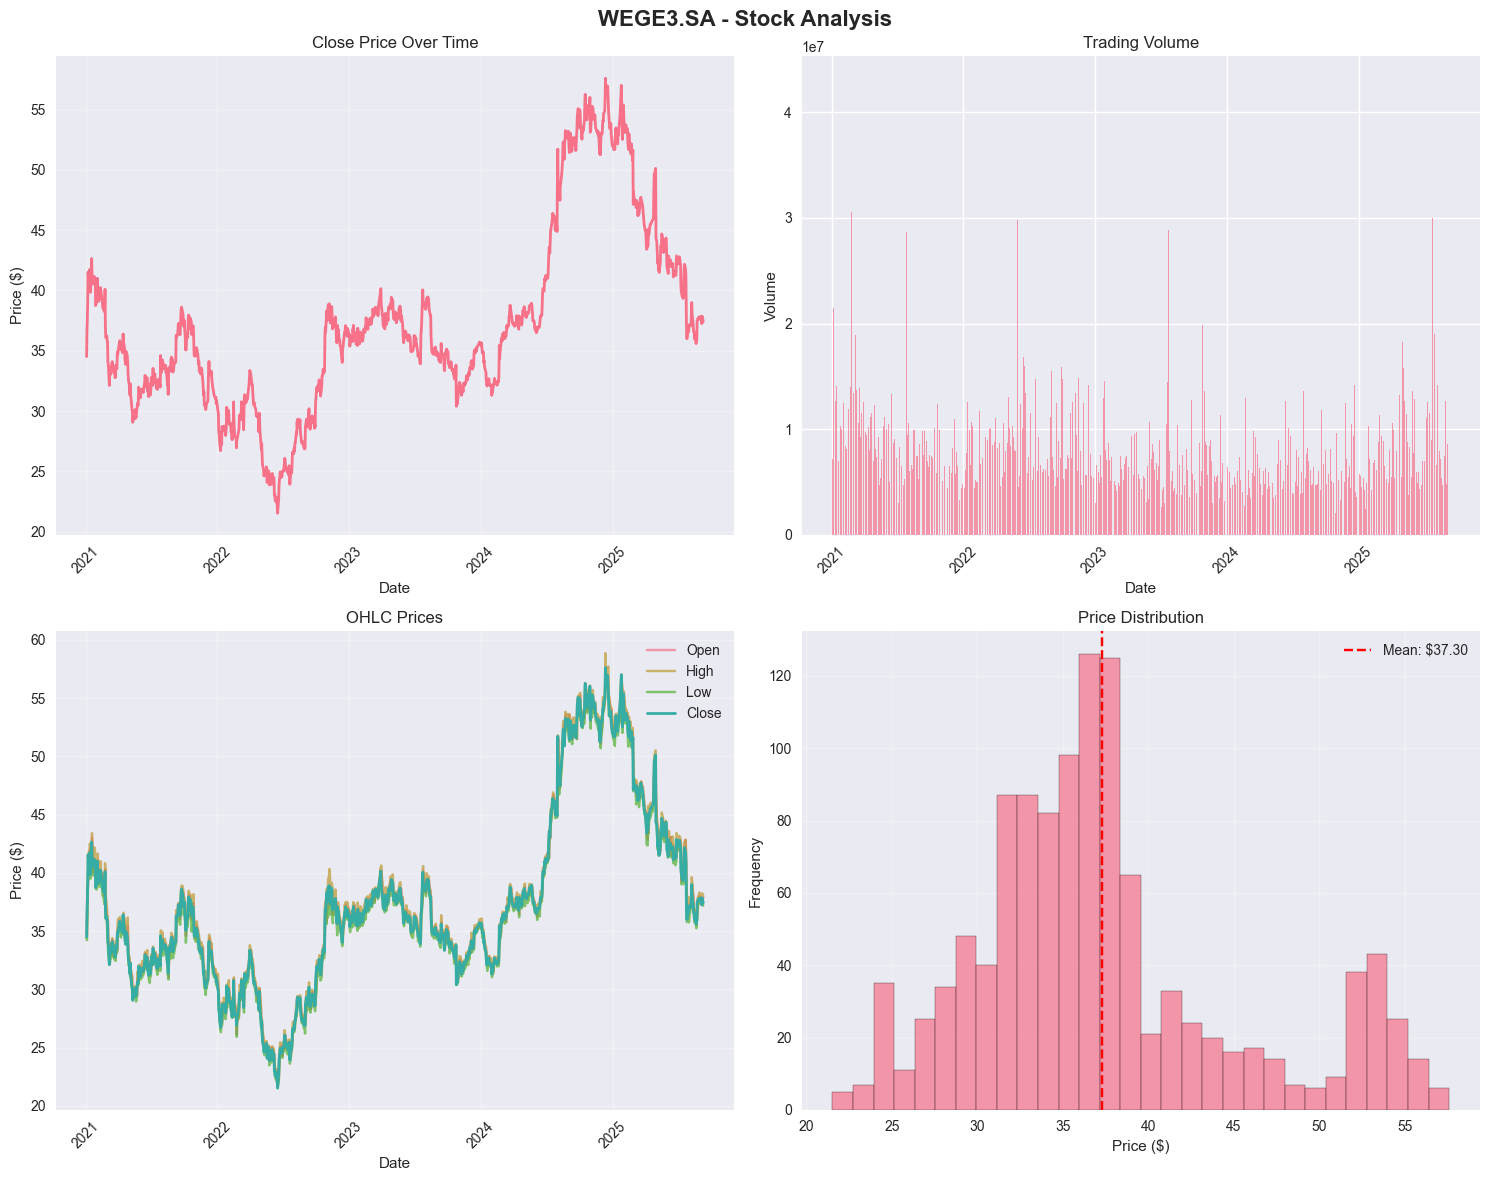

In [17]:
# Plot basic analysis
print("\nGenerating basic analysis plots...")
plot_stock_price_matplotlib(data, symbol)


In [18]:
# Generate forecasts
print("\n🤖 Generating forecasts...")

models = {
    'Simple Neural Network': forecast_simple_nn,
    'Linear Regression': forecast_linear_regression,
    'Random Forest': forecast_random_forest,
    'Moving Average': forecast_moving_average
}

forecasts = {}
for model_name, model_func in models.items():
    print(f"   Running {model_name}...")
    forecast = model_func(data['Close'])
    forecasts[model_name] = forecast

# Display forecast results
print("\n7-Day Forecasted Prices:")
print("-" * 60)

forecast_dates = pd.date_range(
    start=pd.to_datetime(data['Date'].iloc[-1]) + pd.Timedelta(days=1), 
    periods=7, freq='D'
)

# Create forecast dataframe
forecast_df = pd.DataFrame({'Date': forecast_dates})
for model_name, forecast in forecasts.items():
    forecast_df[model_name] = forecast.round(2)

print(forecast_df.to_string(index=False))



🤖 Generating forecasts...
   Running Simple Neural Network...
   Running Linear Regression...
   Running Random Forest...
   Running Moving Average...

7-Day Forecasted Prices:
------------------------------------------------------------
      Date  Simple Neural Network  Linear Regression  Random Forest  Moving Average
2025-09-09                  37.44              37.49          37.75           37.50
2025-09-10                  37.35              37.44          37.61           37.55
2025-09-11                  37.36              37.48          37.75           37.61
2025-09-12                  37.40              37.46          37.65           37.66
2025-09-13                  37.38              37.46          37.62           37.72
2025-09-14                  37.36              37.45          37.76           37.78
2025-09-15                  37.29              37.45          37.76           37.83


In [19]:
# Plot forecasts
print("\nGenerating forecast visualization...")
try:
    plot_forecasts_plotly(data, forecasts, symbol)
except:
    print("Generating matplotlib forecast plots...")
    plot_forecast_comparison_matplotlib(data, forecasts, symbol)



Generating forecast visualization...


In [20]:
# Model performance summary
current_price = float(data['Close'].iloc[-1])
print(f"\nForecast Summary (Current Price: ${current_price:.2f})")
print("-" * 60)

for model_name, forecast in forecasts.items():
    avg_forecast = np.mean(forecast)
    price_change = avg_forecast - current_price
    percent_change = (price_change / current_price) * 100
    print(f"{model_name:20}: ${avg_forecast:.2f} ({percent_change:+.2f}%)")



Forecast Summary (Current Price: $37.44)
------------------------------------------------------------
Simple Neural Network: $37.37 (-0.20%)
Linear Regression   : $37.46 (+0.06%)
Random Forest       : $37.70 (+0.69%)
Moving Average      : $37.66 (+0.60%)
